In [31]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency
from scipy.stats.contingency import odds_ratio
from scipy import stats
from functools import reduce
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import sys
sys.path.append("../src")
import utils.parsing as utpa
import utils.plotting as utpl

# plotting
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
import forestplot as fp
import upsetplot

from scipy.stats import ttest_ind

# Normalize and add info
1. Scale BMI by ancestry, sex and age
2. Add combo info
3. Divide residuals and prs into categories

In [2]:
def get_scaled_bmi(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    # define encoders
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    # save the residuals for bmi
    df['bmi_residuals'] = y - model.predict(X)
    return df


def create_bmi_res_prs_decile_data(phenotype_df, all_combo_samples):
    categorical_cols = ["genetic_sex"]
    numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
    scaled_numerical_cols = []#["bmi_prs"]

    phenotype_df = get_scaled_bmi(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)
    phenotype_df["bmi_res_decile"] = pd.qcut(phenotype_df.bmi_residuals, q=10)
    phenotype_df["bmi_res_decile_num"] = pd.qcut(phenotype_df.bmi_residuals, q=10, labels=False)
    phenotype_df["bmi_prs_decile"] = pd.qcut(phenotype_df.bmi_prs, q=10)
    phenotype_df["bmi_prs_decile_num"] = pd.qcut(phenotype_df.bmi_prs, q=10, labels=False)
    phenotype_df["carrier"] = phenotype_df.sample_names.isin(all_combo_samples)
    phenotype_df["bmi_res_categories"] = phenotype_df.bmi_res_decile_num.map({
        0: "underweight", 
        1:"normal", 2:"normal", 
        3:"overweight", 4:"overweight", 5:"overweight", 6:"overweight", 7:"overweight",
        8:"obese", 9:"severe obesity"
        })
    phenotype_df["bmi_prs_categories"] = phenotype_df.bmi_prs_decile_num.map({
        0: "lowest", 
        1:"middle", 2:"middle", 
        3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
        8:"middle", 9:"highest"
        })
    mean_bmi_dict = phenotype_df.groupby("bmi_res_categories")["bmi"].mean().to_dict()
    return phenotype_df, mean_bmi_dict

In [3]:
cohort_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

In [4]:
cohort_df = pd.read_csv(
    cohort_file, 
    usecols=["sample_names", "genetic_sex", "age"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"])
cohort_df["sample_names"] = cohort_df.sample_names.astype(str)
combo_genes, combo_samples = utpa.get_combo_info_from_files(combo_files)

phenotype_samples_df, mean_bmi_dict = create_bmi_res_prs_decile_data(cohort_df, combo_samples)

# PRS comparison per BMI residual category plot

In [5]:
def create_decile_rank_plot(phenotype_samples_df, bmi_dict):
    fig,ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True, height_ratios=(4, 4))
    ## BMI prs box plots
    sns_ax = sns.boxplot(
        phenotype_samples_df, x="bmi_res_categories", y="bmi_prs", hue="carrier", hue_order=[False, True],
        order=["underweight", "normal", "overweight", "obese", "severe obesity"],
        width=0.65, linewidth=1.25, fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'},
        medianprops={'color':'k'},
        linecolor='k',
        palette= ["whitesmoke", sns.color_palette("Reds", 15).as_hex()[7]],
        legend=True, gap=0.25, ax=ax[0])
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].spines[['right', 'top']].set_visible(False)
    ax[0].hlines([3 for i in range(5)], [(i-0.25+i*0.001953125) for i in range(0, 5)], [(i+0.25+i*0.001953125) for i in range(0,5)], color="k")
    for i, (res_cat) in enumerate(["underweight", "normal", "overweight", "obese", "severe obesity"]):
        psd = phenotype_samples_df.loc[phenotype_samples_df.bmi_res_categories==res_cat]
        ttest_res = ttest_ind(psd.loc[psd.carrier==True, "bmi_prs"], psd.loc[psd.carrier==False, "bmi_prs"], alternative="less")
        ttest_pval = ttest_res.pvalue
        if ttest_pval<0.05:
            pval_text = "*"
            if ttest_pval<0.001:
                pval_text = "**"
                # pval_text = f"P = {ttest_pval:.1E}"
            ax[0].text(0.+i, 3.05, pval_text, ha="center", va="bottom", fontsize=14)
    h,l = ax[0].get_legend_handles_labels()
    ax[0].legend_.remove()
    fig.legend(h,l, ncol=2, loc=(0.35, 0.5025), frameon=False)
    ax[0].set_ylabel("BMI PRS")
    
    phenotype_combo_samples_decile_df = phenotype_samples_df.loc[phenotype_samples_df.carrier==True].groupby("bmi_res_categories", observed=True).agg({
        "sample_names": "count",
        "bmi_prs": "median",
        "bmi_residuals": "mean"}
        ).reset_index()

    ## Combo per decile barplot
    ax[1].bar(phenotype_combo_samples_decile_df.bmi_res_categories, phenotype_combo_samples_decile_df.sample_names, width=0.75, color=sns.color_palette("Reds", 15).as_hex()[7], edgecolor="k")
    ax[1].set_xlabel("BMI Residuals Categories")
    ax[1].set_ylabel("Number of individuals")
    # g.bar_label([g.containers[i] for i in range])
    rects = ax[1].patches
    # Make some labels.
    for rect in rects:
        height = rect.get_height()
        ax[1].text(
            rect.get_x() + rect.get_width() / 2, height + 5, f"{height}", ha="center", va="bottom"
        )
    # ax[1].set_ylim(-100, 3500)
    ax[1].spines[['right', 'top']].set_visible(False)
    ax[1].set_xticklabels([f"{l.get_text()}\n{round(bmi_dict[l.get_text()], 2)}" for l in ax[1].get_xticklabels()])
    return fig,ax


(<Figure size 432x864 with 2 Axes>,
 array([<AxesSubplot: xlabel='bmi_res_categories', ylabel='BMI PRS'>,
        <AxesSubplot: xlabel='BMI Residuals Categories', ylabel='Number of individuals'>],
       dtype=object))

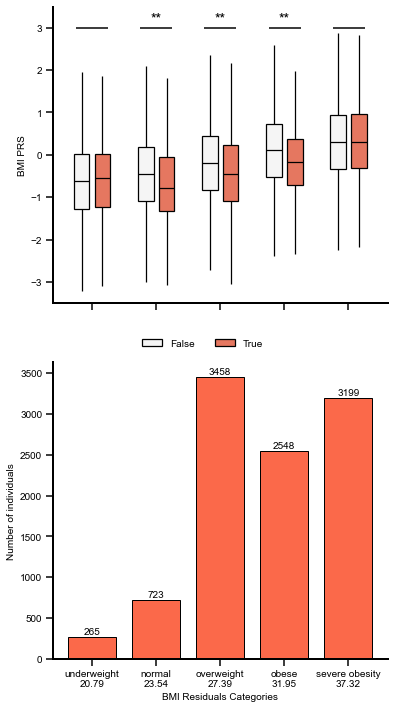

In [6]:
create_decile_rank_plot(phenotype_samples_df, mean_bmi_dict)

# PRS category by BMI residual categories

In [7]:
def get_prs_percent_by_prs(df):
    df1 = df.groupby("bmi_prs_categories")["bmi_res_categories"].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    return df1

def create_bmi_res_cat_prs_cat_df(phenotype_samples_df):
    noncombo = get_prs_percent_by_prs(phenotype_samples_df.loc[phenotype_samples_df.carrier==False])
    noncombo["carrier"] = False
    combo = get_prs_percent_by_prs(phenotype_samples_df.loc[phenotype_samples_df.carrier==True])
    combo["carrier"] = True
    plot_df = pd.concat((combo, noncombo))
    return plot_df


def get_prs_bmi_res_decile_plot(plot_df, bmi_dict, hue="bmi_prs_categories", hue_order=["lowest", "middle", "highest"]):
    g = sns.catplot(data=plot_df, 
        x="bmi_res_categories",
        y="percent",
        hue=hue,
        kind="bar",
        height=4, aspect=2,
        order=["underweight", "normal", "overweight", "obese", "severe obesity"],
        hue_order=hue_order,
        row="carrier",
        palette=["silver", "gray", "black"]
        )

    g.set(ylim=(0,100))
    
    g.axes.flat[1].set_xticklabels([f"{l.get_text()}\n{round(bmi_dict[l.get_text()], 2)}" for l in  g.axes.flat[1].get_xticklabels()])

    for ax in g.axes.flat:
        rects = ax.patches
        for rect in rects:
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2, height + 1, f"{round(height, 2)}%", ha="center", va="bottom"
            )
    return g.figure



In [8]:
bmi_res_cat_prs_cat_df = create_bmi_res_cat_prs_cat_df(phenotype_samples_df)

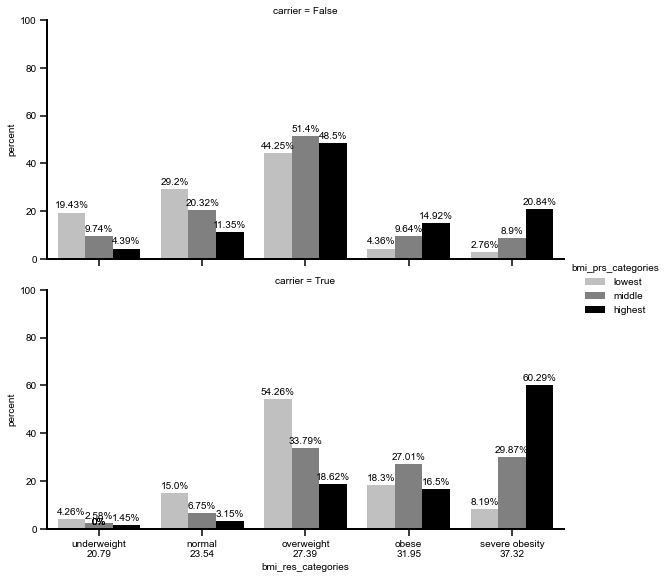

In [9]:
f = get_prs_bmi_res_decile_plot(bmi_res_cat_prs_cat_df, mean_bmi_dict)

# Comorbidities enriched in 
1. People with highest residuals (severely obese)
2. People with combos

In [10]:
icd_raw_dir = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/icd_raw"
icd_codes_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/icd_tree/coding19.tsv"
hes_info_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/hes_info/hes_info.csv.gz"

In [11]:
icd_samples_df = utpa.create_icd_samples_file(icd_raw_dir)
icd_codes_df = pd.read_csv(icd_codes_file, usecols=["coding", "meaning", "node_id", "parent_id"], sep="\t")
icd_codes_df["coding"] = icd_codes_df.coding.str.replace(" ", "")
pheno_tree, root_pheno, c2nodeid_dict = utpa.create_tree(icd_codes_df, icd_samples_df)
hes_info_df = pd.read_csv(hes_info_file, dtype={"sample_names": str, "hes_info": float})
all_icd_samples = set(hes_info_df.loc[hes_info_df.hes_info>0, "sample_names"].values)
print(f"Samples in cohort {len(phenotype_samples_df)}")
phenotype_samples_df = phenotype_samples_df.loc[phenotype_samples_df.sample_names.isin(all_icd_samples)]
print(f"Samples with icd {len(phenotype_samples_df)}")
print(f"Samples with combo {len(combo_samples)}")
combo_samples = combo_samples.intersection(all_icd_samples)
print(f"Samples with combo and icd {len(combo_samples)}")

Samples in cohort 427639
Samples with icd 383253
Samples with combo 10193
Samples with combo and icd 9269


In [12]:
def get_table_icd(samples_of_interest, nonsamples_of_interest, comorbid_samples, field, shortlist):
    table = [
        [len(samples_of_interest.intersection(comorbid_samples)), len(samples_of_interest.difference(comorbid_samples))],
        [len(nonsamples_of_interest.intersection(comorbid_samples)), len(nonsamples_of_interest.difference(comorbid_samples))]
    ]
    df = pd.DataFrame(table, columns=[f"{field}", f"No {field}"], index=shortlist)
    return df

def get_icd_enrich(samples_of_interest, nonsamples_of_interest, all_cohort_samples, pheno_tree, icd_codes_df, c2nodeid_dict, shortlist):
    icd_data = []

    for icdc in icd_codes_df.coding.values:
        icdc_node = pheno_tree.node_dict[c2nodeid_dict[icdc]]
        comorbid_samples = icdc_node.get_samples()
        comorbid_samples = all_cohort_samples.intersection(comorbid_samples)
        df = get_table_icd(samples_of_interest, nonsamples_of_interest, comorbid_samples, icdc_node.meaning, shortlist)
        res = fisher_exact(df)
        or_study = odds_ratio(df)
        cil, cih = or_study.confidence_interval(confidence_level=0.95)
        icdc_node_data = (icdc, icdc_node.meaning, df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], or_study.statistic, res.pvalue, cil, cih)
        icd_data.append(icdc_node_data)
    
    icd_df = pd.DataFrame(icd_data, columns=["icd_code", "icd_meaning", f"{shortlist[0]}_comorbid", f"{shortlist[0]}_noncomorbid", f"{shortlist[1]}_comorbid", f"{shortlist[1]}_noncomorbid", "odds_ratio", "p_value", "ci_low", "ci_high"])
    icd_df["FDR"] = stats.false_discovery_control(icd_df.p_value)
    return icd_df

In [13]:
severely_obese_samples = set(phenotype_samples_df.loc[phenotype_samples_df.bmi_res_categories=="severe obesity", "sample_names"].values)
notseverely_obese_samples = set(phenotype_samples_df.loc[phenotype_samples_df.bmi_res_categories!="severe obesity", "sample_names"].values)
all_samples = set(phenotype_samples_df.sample_names.values)

icd_enrich_file = "/data6/deepro/ukb_bmi/3_characterization/data/pilot/severe_obesity_icd_enrich.csv"
if not os.path.exists(icd_enrich_file):
    severely_obese_samples_enrich_df = get_icd_enrich(severely_obese_samples, notseverely_obese_samples, all_samples, pheno_tree, icd_codes_df, c2nodeid_dict, ["severely obese", "not severely obese"])
    severely_obese_samples_enrich_df.to_csv(icd_enrich_file)
else:
    severely_obese_samples_enrich_df = pd.read_csv(icd_enrich_file)

In [304]:
def get_level(icd_node, level):
    if icd_node.parent:
        return get_level(icd_node.parent, level+1)
    else:
        return level

def add_more_info(pheno_tree, code, odds, fdr, c2nodeid_dict):
    icd_node = pheno_tree.node_dict[c2nodeid_dict[code]]
    icd_node.fdr = fdr
    icd_node.odds = odds
    icd_node.level = get_level(icd_node, 0)
    return


def filter_icd_enrich(icd_df, pheno_tree, root_pheno, c2nodeid_dict):
    for num, row in icd_df.iterrows():
        code, odds, fdr = row.icd_code, row.odds_ratio, row.FDR
        add_more_info(pheno_tree, code, odds, fdr, c2nodeid_dict)
    root_pheno.fdr=1
    root_pheno.level=0
    root_pheno.odds=1

    df_columns = ["level", "node_id", "num_samples", "parent", "meaning", "coding", "fdr", "odds_ratio"]
    df_data_dict = {c:[] for c in df_columns}

    def save_data(curr_node):
        df_data_dict["level"].append(curr_node.level)
        df_data_dict["node_id"].append(curr_node.node)
        df_data_dict["num_samples"].append(len(curr_node.samples))
        if curr_node.parent:
            df_data_dict["parent"].append(curr_node.parent.meaning)
        else:
            df_data_dict["parent"].append("")
        df_data_dict["meaning"].append(curr_node.meaning)
        df_data_dict["coding"].append(curr_node.code)
        df_data_dict["fdr"].append(curr_node.fdr)
        df_data_dict["odds_ratio"].append(curr_node.odds)
        return

    def add_all_parents(curr_node, saved_nodes):
        if curr_node.parent:
            if curr_node.parent not in saved_nodes:
                save_data(curr_node.parent)
                saved_nodes.add(curr_node.parent)
                return add_all_parents(curr_node.parent, saved_nodes)
        return saved_nodes
    
    saved_nodes = set()
    for i,row in icd_df.loc[icd_df.FDR<0.05].iterrows():
        code = row.icd_code
        icd_node = pheno_tree.node_dict[c2nodeid_dict[code]]
        if icd_node not in saved_nodes:
            save_data(icd_node)
            saved_nodes.add(icd_node)
            saved_nodes.update(add_all_parents(icd_node, saved_nodes))

    # filter the phenotypes
    max_level=2
    df_data = pd.DataFrame(df_data_dict)
    df_data = df_data.loc[(df_data.level>0)&(df_data.level<max_level+1)].replace("Root Phenotype", "")
    df_data = df_data.loc[~((df_data.level==max_level)&(df_data.fdr>0.05))] # &(df_data.odds_ratio>1)
    df_data = df_data.loc[~(df_data.odds_ratio<1)]
    df_data["fdr_rank"] = df_data.fdr.rank()
    df_data["fdr_rank_inv"] = df_data.fdr_rank.apply(lambda x: 1/x)
    return df_data

In [305]:
obesity_related_comorbid_df = filter_icd_enrich(severely_obese_samples_enrich_df, pheno_tree, root_pheno, c2nodeid_dict)
obesity_related_comorbid_df = obesity_related_comorbid_df.loc[obesity_related_comorbid_df.level==2]
obesity_related_comorbid_df = obesity_related_comorbid_df.loc[~obesity_related_comorbid_df.meaning.str.lower().str.contains("obesity")] 
# eliminate external factors from ICD file: https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=40001
obesity_related_comorbid_df = obesity_related_comorbid_df.loc[~obesity_related_comorbid_df.parent.str.startswith(("Chapter XV", "Chapter XX", "Chapter XXI"))]

In [306]:
len(obesity_related_comorbid_df)

117

## Combos enrichment for phenotypes within bmi residual categories

In [307]:
def get_combos_icd_enrichment(phenotype_samples_df, bmi_res_category, pheno_tree, c2nodeid_dict, comorbid_df):
    cat_combo_samples = set(phenotype_samples_df.loc[(phenotype_samples_df.bmi_res_categories==bmi_res_category)&(phenotype_samples_df.carrier==True), "sample_names"].values)
    cat_noncombo_samples = set(phenotype_samples_df.loc[(phenotype_samples_df.bmi_res_categories==bmi_res_category)&(phenotype_samples_df.carrier==False), "sample_names"].values)
    cat_samples = set(phenotype_samples_df.loc[phenotype_samples_df.bmi_res_categories==bmi_res_category, "sample_names"].values)
    # individual icd enrichment
    combo_samples_enrich_df = get_icd_enrich(cat_combo_samples, cat_noncombo_samples, cat_samples, pheno_tree, comorbid_df, c2nodeid_dict, ["combo", "non combo"])
    # all comorbidity enrichment
    orc_samples = set()
    for icdc in comorbid_df.sort_values("fdr").coding.values:
        icdc_node = pheno_tree.node_dict[c2nodeid_dict[icdc]]
        comorbid_samples = icdc_node.get_samples()
        comorbid_samples = cat_samples.intersection(comorbid_samples)
        orc_samples.update(comorbid_samples)
    df = get_table_icd(cat_combo_samples, cat_noncombo_samples, orc_samples, "obesity related comorbidity", ["Combo", "Non Combo"])
    res = fisher_exact(df)
    or_study = odds_ratio(df)
    cil, cih = or_study.confidence_interval(confidence_level=0.95)
    all_comorbid_data = ("All", "Obesity Related Comorbidities", df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], or_study.statistic, res.pvalue, cil, cih)
    all_comorbid_df = pd.Series(all_comorbid_data, index=["icd_code", "icd_meaning", f"combo_comorbid", f"combo_noncomorbid", f"noncombo_comorbid", f"noncombo_noncomorbid", "odds_ratio", "p_value", "ci_low", "ci_high"])
    return combo_samples_enrich_df, all_comorbid_df

In [308]:
severely_obese_combo_ind_enrich_df, severely_obese_combo_enrich_df = get_combos_icd_enrichment(phenotype_samples_df, "severe obesity", pheno_tree, c2nodeid_dict, obesity_related_comorbid_df)

In [309]:
severely_obese_combo_enrich_df

icd_code                                          All
icd_meaning             Obesity Related Comorbidities
combo_comorbid                                   2856
combo_noncomorbid                                 138
noncombo_comorbid                               35681
noncombo_noncomorbid                             1413
odds_ratio                                   0.819571
p_value                                       0.03397
ci_low                                       0.684659
ci_high                                      0.987422
dtype: object

In [310]:
len(severely_obese_combo_ind_enrich_df), len(severely_obese_combo_ind_enrich_df.loc[severely_obese_combo_ind_enrich_df.odds_ratio<1])

(117, 75)

In [311]:
obese_combo_ind_enrich_df, obese_combo_enrich_df = get_combos_icd_enrichment(phenotype_samples_df, "obese", pheno_tree, c2nodeid_dict, obesity_related_comorbid_df)

In [312]:
obese_combo_enrich_df

icd_code                                          All
icd_meaning             Obesity Related Comorbidities
combo_comorbid                                   2216
combo_noncomorbid                                 125
noncombo_comorbid                               35178
noncombo_noncomorbid                             1895
odds_ratio                                   0.954989
p_value                                      0.628808
ci_low                                       0.792215
ci_high                                      1.159684
dtype: object

In [313]:
len(obese_combo_ind_enrich_df), len(obese_combo_ind_enrich_df.loc[obese_combo_ind_enrich_df.odds_ratio<1])

(117, 66)

In [314]:
def get_pgs_icd_enrichment(phenotype_samples_df, bmi_res_category, pheno_tree, c2nodeid_dict, comorbid_df):
    cat_pgs_samples = set(phenotype_samples_df.loc[(phenotype_samples_df.bmi_res_categories==bmi_res_category)&(phenotype_samples_df.bmi_prs_categories=="highest"), "sample_names"].values)
    cat_nonpgs_samples = set(phenotype_samples_df.loc[(phenotype_samples_df.bmi_res_categories==bmi_res_category)&(phenotype_samples_df.bmi_prs_categories!="highest"), "sample_names"].values)
    cat_samples = set(phenotype_samples_df.loc[phenotype_samples_df.bmi_res_categories==bmi_res_category, "sample_names"].values)
    # individual icd enrichment
    pgs_samples_enrich_df = get_icd_enrich(cat_pgs_samples, cat_nonpgs_samples, cat_samples, pheno_tree, comorbid_df, c2nodeid_dict, ["pgs", "non pgs"])
    # all comorbidity enrichment
    orc_samples = set()
    for icdc in comorbid_df.sort_values("fdr").coding.values:
        icdc_node = pheno_tree.node_dict[c2nodeid_dict[icdc]]
        comorbid_samples = icdc_node.get_samples()
        comorbid_samples = cat_samples.intersection(comorbid_samples)
        orc_samples.update(comorbid_samples)
    df = get_table_icd(cat_pgs_samples, cat_nonpgs_samples, orc_samples, "obesity related comorbidity", ["pgs", "Non pgs"])
    res = fisher_exact(df)
    or_study = odds_ratio(df)
    cil, cih = or_study.confidence_interval(confidence_level=0.95)
    all_comorbid_data = ("All", "Obesity Related Comorbidities", df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], or_study.statistic, res.pvalue, cil, cih)
    all_comorbid_df = pd.Series(all_comorbid_data, index=["icd_code", "icd_meaning", f"pgs_comorbid", f"pgs_noncomorbid", f"nonpgs_comorbid", f"nonpgs_noncomorbid", "odds_ratio", "p_value", "ci_low", "ci_high"])
    return pgs_samples_enrich_df, all_comorbid_df

In [315]:
severely_obese_pgs_ind_enrich_df, severely_obese_pgs_enrich_df = get_pgs_icd_enrichment(phenotype_samples_df, "severe obesity", pheno_tree, c2nodeid_dict, obesity_related_comorbid_df)

In [317]:
severely_obese_pgs_enrich_df

icd_code                                        All
icd_meaning           Obesity Related Comorbidities
pgs_comorbid                                   8478
pgs_noncomorbid                                 329
nonpgs_comorbid                               30059
nonpgs_noncomorbid                             1222
odds_ratio                                 1.047596
p_value                                    0.472109
ci_low                                     0.924471
ci_high                                    1.189678
dtype: object

In [318]:
len(severely_obese_pgs_ind_enrich_df), len(severely_obese_pgs_ind_enrich_df.loc[severely_obese_pgs_ind_enrich_df.odds_ratio<1])

(117, 50)